<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [1]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [4]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FHFFHFFF', 'FFFFHFFH', 'FFFFFFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [5]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

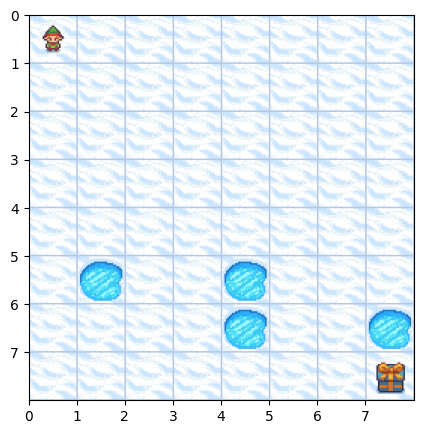

In [7]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [8]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 2 , move right , 1 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 2 , move right , 2 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 2 , move right , 3 , 0.0 , False , False , {'prob': 1.0}
passo 4 : 0 , move left , 2 , 0.0 , False , False , {'prob': 1.0}
passo 5 : 2 , move right , 3 , 0.0 , False , False , {'prob': 1.0}
passo 6 : 2 , move right , 4 , 0.0 , False , False , {'prob': 1.0}
passo 7 : 0 , move left , 3 , 0.0 , False , False , {'prob': 1.0}
passo 8 : 0 , move left , 2 , 0.0 , False , False , {'prob': 1.0}
passo 9 : 1 , move down , 10 , 0.0 , False , False , {'prob': 1.0}
passo 10 : 0 , move left , 9 , 0.0 , False , False , {'prob': 1.0}
passo 11 : 0 , move left , 8 , 0.0 , False , False , {'prob': 1.0}
passo 12 : 0 , move left , 8 , 0.0 , False , False , {'prob': 1.0}
passo 13 : 2 , move right , 9 , 0.0 , False , False , {'prob': 1.0}
passo 14 : 0 , move left , 8 , 0.0 , False , False , {'prob':

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 66 : move left , 41 , 0.0 , True , False , {'prob': 1.0}


In [10]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [11]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [20]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


Using Sarsa method
Using Q-learning method


In [21]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [22]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [32]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  after_training = "after_training_sarsa.mp4" if is_using_Sarsa else "after_training_q.mp4"
  record_trained_video(agent, after_training, env.spec.max_episode_steps)
  env.close()
  return after_training, rewards, steps, accuracies

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


  1%|▏         | 132/10000 [00:00<00:24, 409.44it/s]

step: 2443, episode: 100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1


  3%|▎         | 255/10000 [00:00<00:22, 439.09it/s]

step: 4989, episode: 200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


  4%|▎         | 364/10000 [00:00<00:20, 463.74it/s]

step: 6945, episode: 300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  5%|▍         | 484/10000 [00:01<00:29, 324.66it/s]

step: 9158, episode: 400, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.1


  6%|▌         | 600/10000 [00:01<00:24, 386.76it/s]

step: 11191, episode: 500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 13039, episode: 600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  8%|▊         | 800/10000 [00:01<00:20, 452.09it/s]

step: 14904, episode: 700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 16903, episode: 800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 10%|▉         | 971/10000 [00:02<00:27, 329.17it/s]

step: 18923, episode: 900, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 11%|█         | 1071/10000 [00:02<00:24, 371.37it/s]

step: 20875, episode: 1000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 12%|█▏        | 1176/10000 [00:03<00:34, 257.11it/s]

step: 23503, episode: 1100, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.1


 13%|█▎        | 1271/10000 [00:03<00:27, 319.68it/s]

step: 25612, episode: 1200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 14%|█▍        | 1400/10000 [00:03<00:19, 432.77it/s]

step: 27634, episode: 1300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 29483, episode: 1400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 16%|█▌        | 1613/10000 [00:04<00:16, 514.09it/s]

step: 31618, episode: 1500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 34217, episode: 1600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 18%|█▊        | 1781/10000 [00:04<00:12, 640.73it/s]

step: 35992, episode: 1700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 38110, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 20%|██        | 2001/10000 [00:04<00:11, 687.42it/s]

step: 39826, episode: 1900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 41514, episode: 2000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 22%|██▏       | 2218/10000 [00:05<00:11, 697.99it/s]

step: 43499, episode: 2100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 45221, episode: 2200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 24%|██▍       | 2444/10000 [00:05<00:10, 694.74it/s]

step: 47194, episode: 2300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 49154, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 26%|██▌       | 2593/10000 [00:05<00:10, 714.20it/s]

step: 50944, episode: 2500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 53355, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2819/10000 [00:05<00:10, 709.31it/s]

step: 55114, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 56664, episode: 2800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2970/10000 [00:06<00:10, 655.57it/s]

step: 58735, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 61433, episode: 3000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:06<00:09, 706.57it/s]

step: 63199, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 64825, episode: 3200, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3372/10000 [00:06<00:09, 680.53it/s]

step: 66741, episode: 3300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 69295, episode: 3400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3584/10000 [00:07<00:10, 599.04it/s]

step: 71055, episode: 3500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3646/10000 [00:07<00:15, 413.08it/s]

step: 74942, episode: 3600, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.1


 38%|███▊      | 3800/10000 [00:07<00:14, 426.02it/s]

step: 76742, episode: 3700, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 78408, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3942/10000 [00:08<00:11, 523.14it/s]

step: 80338, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4085/10000 [00:08<00:12, 467.59it/s]

step: 82305, episode: 4000, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1


 42%|████▏     | 4216/10000 [00:08<00:13, 431.49it/s]

step: 84328, episode: 4100, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 86154, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4392/10000 [00:08<00:09, 597.63it/s]

step: 87840, episode: 4300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 89747, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4537/10000 [00:09<00:08, 640.51it/s]

step: 91525, episode: 4500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:09<00:10, 507.47it/s]

step: 93672, episode: 4600, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 95498, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4927/10000 [00:09<00:08, 582.78it/s]

step: 97454, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 99345, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5096/10000 [00:10<00:07, 691.54it/s]

step: 101581, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5229/10000 [00:10<00:10, 472.61it/s]

step: 103679, episode: 5100, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 105933, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5393/10000 [00:10<00:09, 480.90it/s]

step: 107703, episode: 5300, accuracy training: 0.99, accuracy test: 0.0, random move probability: 0.1
step: 109695, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5605/10000 [00:11<00:07, 595.30it/s]

step: 111385, episode: 5500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 113069, episode: 5600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5826/10000 [00:11<00:08, 487.40it/s]

step: 115642, episode: 5700, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 117429, episode: 5800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5963/10000 [00:11<00:07, 545.78it/s]

step: 119429, episode: 5900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 121559, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:12<00:07, 483.34it/s]

step: 123897, episode: 6100, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 125744, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6424/10000 [00:12<00:06, 594.42it/s]

step: 127757, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 129946, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6566/10000 [00:13<00:05, 644.66it/s]

step: 132229, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6708/10000 [00:13<00:06, 475.53it/s]

step: 134064, episode: 6600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 136274, episode: 6700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6932/10000 [00:13<00:05, 571.08it/s]

step: 138320, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 140274, episode: 6900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:14<00:09, 313.90it/s]

step: 142625, episode: 7000, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 144600, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7276/10000 [00:15<00:09, 296.13it/s]

step: 146417, episode: 7200, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 74%|███████▍  | 7385/10000 [00:15<00:06, 380.42it/s]

step: 148565, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7490/10000 [00:15<00:08, 292.93it/s]

step: 150733, episode: 7400, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 76%|███████▌  | 7588/10000 [00:16<00:09, 255.73it/s]

step: 152762, episode: 7500, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1


 77%|███████▋  | 7694/10000 [00:16<00:06, 347.65it/s]

step: 154725, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7741/10000 [00:16<00:07, 308.72it/s]

step: 156452, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7837/10000 [00:16<00:06, 345.71it/s]

step: 159436, episode: 7800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7940/10000 [00:17<00:06, 317.58it/s]

step: 161161, episode: 7900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:17<00:04, 417.05it/s]

step: 165182, episode: 8000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.1
step: 166969, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8311/10000 [00:17<00:03, 560.84it/s]

step: 168871, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 171252, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8464/10000 [00:18<00:02, 595.83it/s]

step: 173080, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 175657, episode: 8500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8684/10000 [00:18<00:01, 668.17it/s]

step: 177608, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 179828, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8893/10000 [00:18<00:01, 648.11it/s]

step: 181881, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 184484, episode: 8900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:19<00:01, 624.35it/s]

step: 186903, episode: 9000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1
step: 188746, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:19<00:01, 472.70it/s]

step: 191269, episode: 9200, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 193164, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9503/10000 [00:19<00:00, 574.39it/s]

step: 195334, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 197516, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9733/10000 [00:20<00:00, 660.27it/s]

step: 199507, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 201345, episode: 9700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9885/10000 [00:20<00:00, 684.24it/s]

step: 203350, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:20<00:00, 478.21it/s]

step: 205550, episode: 9900, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1
step: 207899, episode: 10000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


In [35]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

  1%|▏         | 138/10000 [00:01<01:35, 102.81it/s]

step: 6368, episode: 100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.49600000000000155


  3%|▎         | 267/10000 [00:01<00:33, 289.93it/s]

step: 9871, episode: 200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▎         | 363/10000 [00:01<00:25, 378.51it/s]

step: 12275, episode: 300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 466/10000 [00:02<00:22, 432.47it/s]

step: 14500, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 563/10000 [00:02<00:21, 432.55it/s]

step: 16926, episode: 500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 665/10000 [00:02<00:21, 433.03it/s]

step: 19544, episode: 600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 772/10000 [00:02<00:21, 437.94it/s]

step: 22002, episode: 700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 875/10000 [00:03<00:20, 442.23it/s]

step: 24540, episode: 800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 975/10000 [00:03<00:20, 430.38it/s]

step: 26854, episode: 900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1070/10000 [00:03<00:22, 400.80it/s]

step: 29403, episode: 1000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1167/10000 [00:03<00:22, 400.69it/s]

step: 31906, episode: 1100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1265/10000 [00:04<00:20, 416.89it/s]

step: 34337, episode: 1200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▎        | 1366/10000 [00:04<00:19, 440.24it/s]

step: 36696, episode: 1300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1455/10000 [00:04<00:20, 415.89it/s]

step: 38969, episode: 1400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1556/10000 [00:04<00:19, 433.45it/s]

step: 41316, episode: 1500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1652/10000 [00:05<00:19, 430.59it/s]

step: 43521, episode: 1600, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1834/10000 [00:05<00:15, 518.95it/s]

step: 45851, episode: 1700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 48065, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1978/10000 [00:05<00:13, 615.73it/s]

step: 50322, episode: 1900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 52511, episode: 2000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2189/10000 [00:05<00:12, 649.57it/s]

step: 54700, episode: 2100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 56845, episode: 2200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:06<00:12, 620.18it/s]

step: 59017, episode: 2300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 61366, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▋       | 2634/10000 [00:06<00:10, 683.91it/s]

step: 63522, episode: 2500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 65621, episode: 2600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2777/10000 [00:06<00:10, 663.34it/s]

step: 67816, episode: 2700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 69935, episode: 2800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2994/10000 [00:07<00:09, 704.22it/s]

step: 71971, episode: 2900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 74065, episode: 3000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3202/10000 [00:07<00:10, 674.89it/s]

step: 76211, episode: 3100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 78256, episode: 3200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▎      | 3367/10000 [00:07<00:09, 695.73it/s]

step: 80352, episode: 3300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 82370, episode: 3400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3595/10000 [00:07<00:08, 717.80it/s]

step: 84479, episode: 3500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 86510, episode: 3600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3810/10000 [00:08<00:08, 687.91it/s]

step: 88547, episode: 3700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 90507, episode: 3800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3991/10000 [00:08<00:07, 757.54it/s]

step: 92600, episode: 3900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 94647, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4219/10000 [00:08<00:08, 680.76it/s]

step: 96606, episode: 4100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 98582, episode: 4200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:09<00:07, 714.06it/s]

step: 100621, episode: 4300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 102517, episode: 4400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4649/10000 [00:09<00:07, 738.87it/s]

step: 104418, episode: 4500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 106386, episode: 4600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:09<00:07, 714.80it/s]

step: 108342, episode: 4700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 110257, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5014/10000 [00:09<00:07, 684.74it/s]

step: 112170, episode: 4900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.304000000000076
step: 114073, episode: 5000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5200/10000 [00:10<00:06, 732.89it/s]

step: 115995, episode: 5100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 117829, episode: 5200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5396/10000 [00:10<00:05, 802.97it/s]

step: 119691, episode: 5300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 121530, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▋    | 5630/10000 [00:10<00:06, 693.36it/s]

step: 123343, episode: 5500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 125195, episode: 5600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5797/10000 [00:11<00:05, 764.49it/s]

step: 127021, episode: 5700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 128904, episode: 5800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6026/10000 [00:11<00:05, 717.08it/s]

step: 130753, episode: 5900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 132523, episode: 6000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:11<00:05, 746.73it/s]

step: 134326, episode: 6100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 136132, episode: 6200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6396/10000 [00:11<00:04, 794.66it/s]

step: 137887, episode: 6300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 139632, episode: 6400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▋   | 6633/10000 [00:12<00:04, 759.33it/s]

step: 141428, episode: 6500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 143190, episode: 6600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:12<00:04, 750.65it/s]

step: 144937, episode: 6700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 146713, episode: 6800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22800000000009019


 71%|███████   | 7053/10000 [00:12<00:03, 761.11it/s]

step: 148449, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 150251, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7201/10000 [00:12<00:04, 693.72it/s]

step: 151969, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 153732, episode: 7200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:13<00:03, 756.67it/s]

step: 155329, episode: 7300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 157015, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.20400000000008284


 77%|███████▋  | 7654/10000 [00:13<00:03, 770.71it/s]

step: 158668, episode: 7500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 160358, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7808/10000 [00:13<00:03, 724.80it/s]

step: 162027, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 163703, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:13<00:02, 753.34it/s]

step: 165293, episode: 7900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 166940, episode: 8000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1800000000000755


 83%|████████▎ | 8260/10000 [00:14<00:02, 781.88it/s]

step: 168546, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 170159, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8416/10000 [00:14<00:02, 763.87it/s]

step: 171754, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 173381, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:14<00:01, 753.45it/s]

step: 175014, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 176616, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8797/10000 [00:14<00:01, 819.65it/s]

step: 178217, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 179861, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8961/10000 [00:15<00:01, 783.61it/s]

step: 181456, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 183064, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9180/10000 [00:15<00:01, 628.30it/s]

step: 184655, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 186222, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9371/10000 [00:15<00:01, 558.82it/s]

step: 187821, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 189383, episode: 9400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9577/10000 [00:16<00:00, 587.76it/s]

step: 190986, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 192554, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9779/10000 [00:16<00:00, 598.49it/s]

step: 194130, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 195659, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:17<00:00, 583.63it/s]

step: 197171, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 198707, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


In [56]:
max(steps_sarsa)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


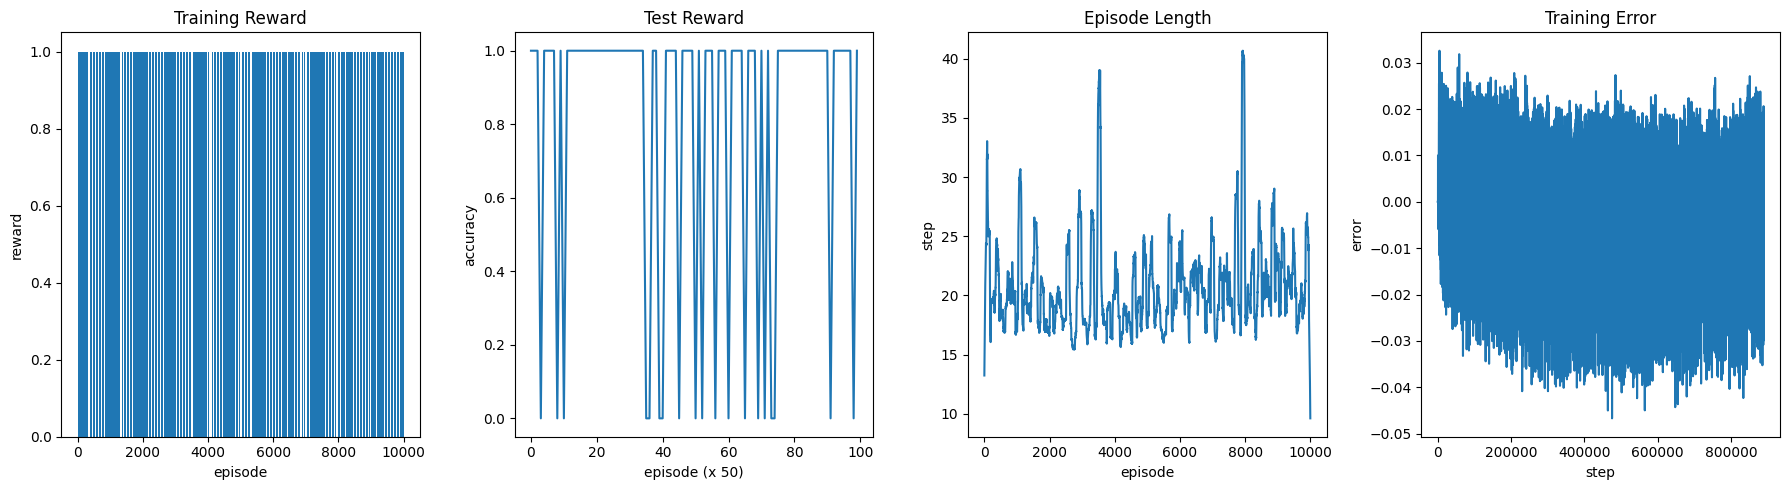

In [36]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

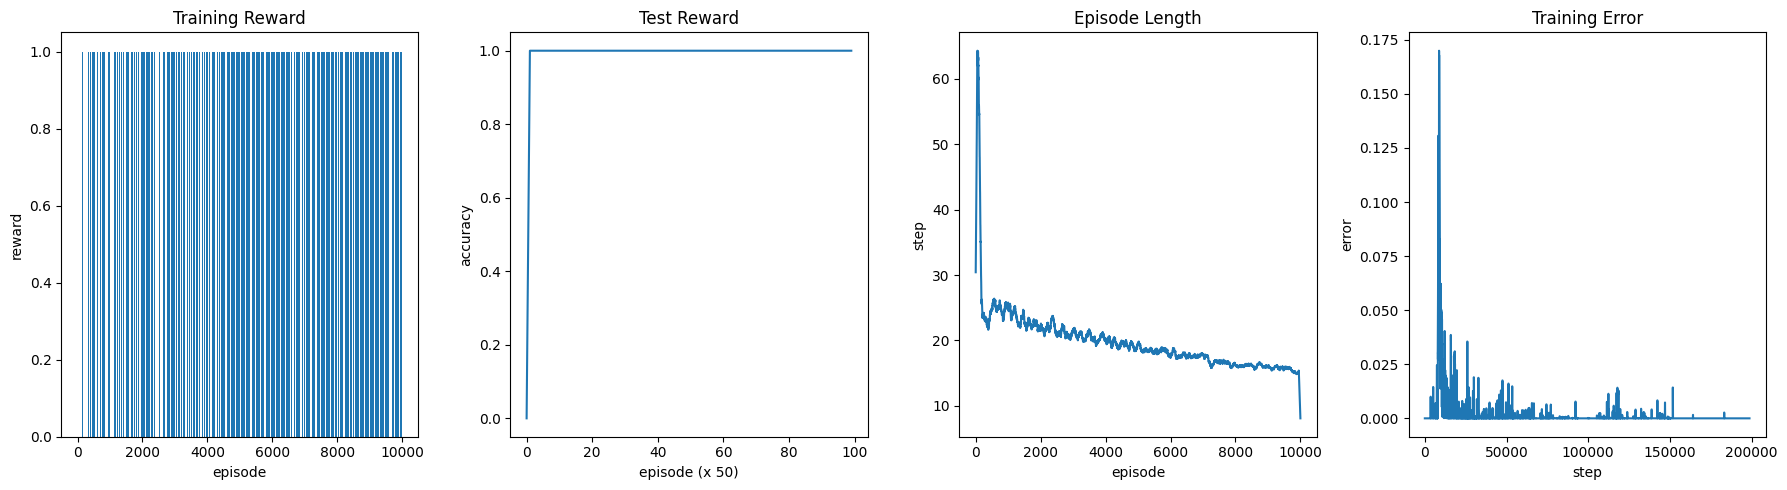

In [37]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [39]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

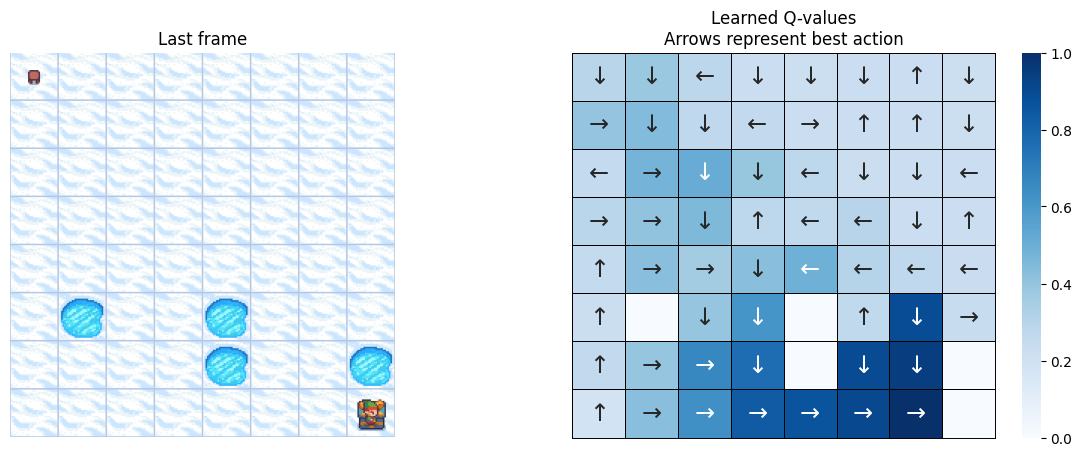

In [40]:
plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


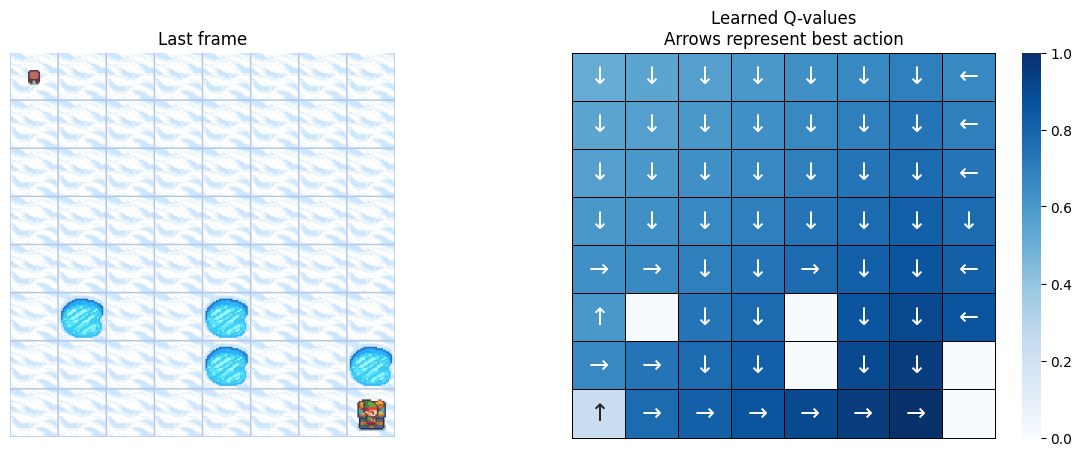

In [41]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

In [42]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

In [43]:
env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [44]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [ ]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)